<a href="https://colab.research.google.com/github/pseeej/MachineLearning_DCLAB/blob/master/DL%20for%20Everyone/20.%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 생성자 모델 만들기
generator = Sequential()   # 모델 이름 generator로 정하고 sequential 함수 호출

# 생성자의 활성화 함수로는 LeakyReLU 사용. ReLU 사용하면 학습이 불안정해지는 경우 많음.
# 임의로 정한 노드의 수 128. input_dim=100은 100차원 크기의 랜덤 벡터를 입력으로.
# UpSampling2D() 함수 때문에 7*7 수행
generator.add(Dense(128*7*7, input_dim = 100, activation=LeakyReLU(0.2)))

# 배치 정규화. 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치. 다음 층으로 입력될 값을 일정하게 재배치하는 역할.
# 층의 개수가 늘어나도 안정적인 학습 진행할 수 있도록 함.
generator.add(BatchNormalization())

# 컨볼루션 레이어가 받아들일 수 있는 형태로 바꿔줌. Conv2D의 input_shape에 들어갈 형태로 지정.
generator.add(Reshape((7, 7, 128)))

# UpSampling2D 함수는 이미지의 가로, 세로 크기를 2배씩 늘려줌. 여기서 7*7이 14*14가 됨
generator.add(UpSampling2D())

# 작은 크기의 이미지 점점 늘려 가면서 컨볼루션 레이어 지남 => DCGAN의 특징
# padding='same'으로 모자라는 부분은 자동으로 0 채워짐
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))

# UpSampling2D 여기서 28*28이 됨
generator.add(UpSampling2D())

# 컨볼루션 과정 한 번 더 거친 후 판별자로 값을 넘길 준비 마침.
# 판별자로 넘겨주기 직전에는 tanh 함수 사용함으로써 출력되는 값을 -1~1 사이로 맞출 수 있음.
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh')) 

In [3]:
# 판별자 모델 만들기
# 진짜/가짜만 구분하면 되므로 UpSampling으로 크기 맞춰줄 필요 X
discriminator = Sequential()

# 노드의 수 64, 커널 크기 5. 5x5 커널 사용함을 확인 가능.
# stride는 kernel window를 몇 칸씩 이동시킬지를 정하는 옵션. 가로, 세로 크기를 줄여줌으로써 새로운 특징 뽑아주는 효과 생김.
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))

# 가로x세로 2차원의 과정을 1차원으로 바꿔주는 함수
discriminator.add(Flatten())

# 마지막 활성화 함수로 sigmoid 사용함으로써 0 또는 1로 결과값 가지게 됨
discriminator.add(Dense(1, activation='sigmoid'))

# 진짜(1) 또는 가짜(0) 둘 중 하나 선택하는 문제이므로 이전과 똑같은 loss, 최적화 함수 사용.
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# 진짜/가짜 판별만 해줘야 함. 자신이 학습해서는 안됨. => 가중치 저장하는 학습 기능 꺼줌.
discriminator.trainable = False

In [4]:
# 생성자와 판별자 모델을 연결시키는 GAN 모델 만들기
ginput = Input(shape=(100,))  # 랜덤한 100개의 벡터를 케라스의 input 함수에 집어넣어 생성자에 입력할 ginput 만듦

# 생성자 모델 generator에 ginput 입력. 이 결과로 출력되는 28x28 크기의 이미지가 판별자 모델의 입력값으로 들어감.
# 판별자는 그 입력 값을 가지고 참과 거짓 판별하게 됨
dis_output = discriminator(generator(ginput)) 

gan = Model(ginput, dis_output) # 새로운 모델 생성
gan.compile(loss='binary_crossentropy', optimizer='adam') # 참/거짓 구분하는 이진 로스 함수와 최적화 함수 사용하여 컴파일 수행.
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


epoch:0  d_loss:0.6991  g_loss:0.6395


FileNotFoundError: ignored

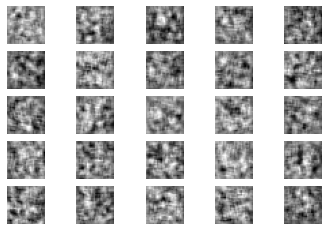

In [5]:
#신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀값은 0에서 255사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          #가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          #판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

gan_train(4001, 32, 200)  #4000번 반복되고(+1을 해 주는 것에 주의), 배치 사이즈는 32,  200번 마다 결과가 저장되게 하였습니다.